In [1]:
import sys
sys.path.append('../../')

import numpy as np
from qiskit import IBMQ, Aer
import matplotlib.pyplot as plt
from main import device_process_measurement_tomography, Quantities, Cross_Quantities, DiamondNorm
from qiskit.compiler import transpile
from qiskit.providers.ibmq.managed import IBMQJobManager
from utils_qiskit import * 
from utils_plots import *

In [2]:
IBMQ.load_account()
# provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
provider = IBMQ.get_provider(hub='ibm-q-research-2', group='csic-1', project='main')
backend = provider.get_backend('ibm_perth')
simulator = Aer.get_backend('aer_simulator')
job_manager = IBMQJobManager()

In [3]:
job_ids = [
            '5d9083dc79634830b84a122d6aabd1e7-16648063248694873',
            'eea890c98b394905a1f5a8d3122686d1-16648063283466015',
            '0ec013b625ec4f9d8b3fbd7f34b2f4fc-16648063318546033',
            '5f201e30ed3a435bb21bd5e0c8975766-16648063354740663',
            'eaf8374145974698a47690d3e69aadda-16648063389969826'
            ]

In [4]:
qndmt_all = device_process_measurement_tomography( backend, parall_qubits=[] )
circs = [ qndmt_all.circuits( name='all' ) ]

qndnt_single = []
for j in range(7):
    qndmt = device_process_measurement_tomography( backend, qubits=[j], parall_qubits=[] )
    qndnt_single.append( qndmt )
    circs.append( qndmt.circuits( name='qubit_{}'.format(j) ) )

circs = [ c for circ in circs for c in circ ]

In [5]:
# results_tomo = []

# for job_str in job_ids:

#     job = job_manager.retrieve_job_set( job_str, provider )
#     result_qiskit = job.results().combine_results()
#     save_results( result_qiskit, job_str)

#     results_tomo_job = [ qndmt_all.fit( result_qiskit ) ]
#     for j in range(7):
#         results_tomo_job.append(  qndnt_single[j].fit( result_qiskit ) ) 
#     np.save( 'data'+job_str, np.array(results_tomo_job,dtype=object))

#     results_tomo.append( results_tomo_job )

In [6]:
for job_str in job_ids[:1]:

    job = job_manager.retrieve_job_set( job_str, provider )
    result_qiskit = job.results().combine_results()
    results_tomo_job = qndnt_single[j].fit( result_qiskit ) 

In [7]:
results_tomo = []

for job_str in job_ids:

    results_tomo.append( np.load( 'data'+job_str+'.npy', allow_pickle=True) )

In [8]:
quantities_pa = []


for i in range(5):
    povms_pa = results_tomo[i][0].single.povms
    chois_pa= results_tomo[i][0].single.chois

    quantities_pa_temp = []
    for j in range(7):
        quantities_pa_temp.append( Quantities( povms_pa[j], chois_pa[j] ) )
    
    quantities_pa.append( quantities_pa_temp )


In [9]:
quantities_in = []
diamond_norms = []

for i in range(5):
    quantities_in_temp = []
    diamond_norms_temp = []

    for j in range(7):
        povms_in = results_tomo[i][j+1].single.povms
        chois_in= results_tomo[i][j+1].single.chois
        quantities_in_temp.append( Quantities( povms_in[0], chois_in[0] ) )
        diamond_norms_temp.append( 0.25*DiamondNorm( chois_in[0][0] - chois_pa[j][0], 'vec'  )
                                    + .25*DiamondNorm( chois_in[0][1] -  chois_pa[j][1], 'vec'  ) )

    quantities_in.append( quantities_in_temp )
    diamond_norms.append( diamond_norms_temp )


In [10]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size"  : 22,
    "font.sans-serif": ["Helvetica"]})

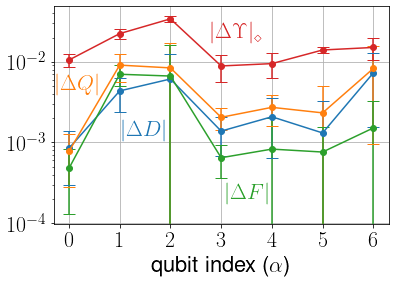

In [22]:
error_mean = np.mean( np.abs( np.array(quantities_pa)-np.array(quantities_in) ), axis=0  )
error_std  = np.std( np.abs( np.array(quantities_pa)-np.array(quantities_in) ), axis=0  )

for j in [2,1,0]:
    plt.errorbar( range(7), error_mean[:,j], error_std[:,j], fmt='-o', capsize=6 )
plt.errorbar( range(7), np.mean(diamond_norms, axis=0), np.std(diamond_norms, axis=0), fmt='-o', capsize=6 )
plt.yscale('log')
plt.xlabel('qubit index ($\\alpha$)')
plt.xticks( [0,1,2,3,4,5,6] )
plt.grid()
plt.text( 3.1, 2e-4, '$|\\Delta F|$', color='tab:green' )
plt.text( -.25, 4.5e-3, '$|\\Delta Q|$', color='tab:orange' )
plt.text( 1.05, 1.2e-3, '$|\\Delta D|$', color='tab:blue' )
plt.text( 2.8, 2e-2, '$|\\Delta\\Upsilon|_\diamond$', color='tab:red' )
plt.savefig('pa_vs_ind_single.png', bbox_inches='tight', transparent=True )
plt.savefig('pa_vs_ind_single.svg', bbox_inches='tight', transparent=True )


In [34]:
error_mean_v2 = np.concatenate( (error_mean , np.array([[7.42011776e-03, 1.01592062e-02, 4.18739850e-03],
                                                        [9.54049387e-04, 9.38843637e-04, 5.96179307e-05]]) ) ) 
error_std_v2  = np.concatenate( (error_std, np.array([[0.00309928, 0.0053046 , 0.00206848],
                                                        [0.0032122 , 0.00685577, 0.00465332]])))

In [32]:
diamond_norms_mean_v2 = np.concatenate( (np.mean(diamond_norms, axis=0), np.array([0.01605136, 0.01413639])) )
diamond_norms_std_v2  = np.concatenate( (np.std(diamond_norms, axis=0) , np.array([0.00294134, 0.00589483])) )

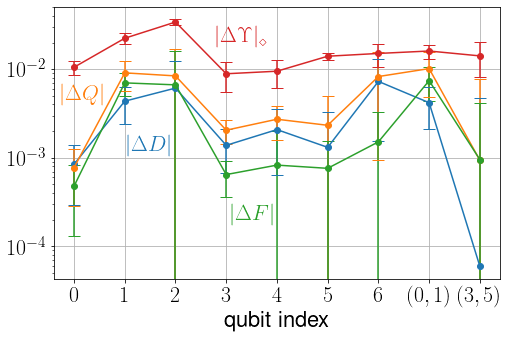

In [45]:
fig, ax = plt.subplots( figsize=(8,5) )

for j in [2,1,0]:
    ax.errorbar( range(9), error_mean_v2[:,j], error_std_v2[:,j], fmt='-o', capsize=6 )
ax.errorbar( range(9), diamond_norms_mean_v2, diamond_norms_std_v2, fmt='-o', capsize=6 )
ax.set_yscale('log')
ax.set_xlabel('qubit index')
ax.set_xticks( [0,1,2,3,4,5,6,7,8] )
ax.set_xticklabels([ '$0$', '$1$', '$2$', '$3$', '$4$', '$5$', '$6$', '$(0,1)$', '$(3,5)$'  ])
ax.grid()
ax.text( 3.1, 2e-4, '$|\\Delta F|$', color='tab:green' )
ax.text( -.25, 4.5e-3, '$|\\Delta Q|$', color='tab:orange' )
ax.text( 1.05, 1.2e-3, '$|\\Delta D|$', color='tab:blue' )
ax.text( 2.8, 2e-2, '$|\\Delta\\Upsilon|_\diamond$', color='tab:red' )
plt.savefig('pa_vs_ind_single_and_double.png', bbox_inches='tight', transparent=True )
plt.savefig('pa_vs_ind_single_and_double.svg', bbox_inches='tight', transparent=True )
plt.savefig('pa_vs_ind_single_and_double.pdf', bbox_inches='tight', transparent=True )